In [6]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/Users/sakka/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [7]:
def one_hot_encoding(label_arr, class_size=5):
    return np.eye(class_size)[label_arr]

In [48]:
dataset_df = pd.DataFrame()

day_lst = ["20170416", "20170417", "20170420", "20170421", "20170422", "20181030", "20181031"]

for day in day_lst:
    tmp_dataset_df = pd.read_csv("../../data/datasets/default/{0}.csv".format(day))

    # check NaN count
    assert tmp_dataset_df.isnull().values.sum() == 0

    dataset_df = pd.concat([dataset_df, tmp_dataset_df]).reset_index(drop=True)

    # shuffle dataset
    #dataset_df = dataset_df.sample(frac=1)
    dataset_df = dataset_df.fillna(0)
    
    # check NaN count
    assert dataset_df.isnull().values.sum() == 0
    
for i in range(5):
    dataset_df.loc[dataset_df["label"] == i+1, "label"] = i
    
print(len(dataset_df))
dataset_df.head()

201179


,Fri,Mon,Sat,Sun,Thurs,Tue,Wed,degree_mean,degree_mean_shift1,degree_std,...,overall_dir_right_up,overall_dir_up,prev_acc_cnt,right,right_down,right_up,up,var,var_shift1,vertical
0,0,0,0,1,0,0,0,125.666667,-27.054264,115.604553,...,0,0.0,0,0.333333,0.071429,0.119048,0.000000,22.5958,21.1866,0.000000
1,0,0,0,1,0,0,0,130.590909,4.924242,118.552504,...,0,0.0,0,0.295455,0.136364,0.113636,0.000000,26.3131,3.7173,0.022727
2,0,0,0,1,0,0,0,146.083333,15.492424,137.548855,...,0,0.0,0,0.361111,0.111111,0.222222,0.027778,27.2595,0.9464,0.027778
3,0,0,0,1,0,0,0,154.648649,8.565315,125.963362,...,0,0.0,0,0.324324,0.054054,0.189189,0.000000,26.6687,-0.5908,0.000000
4,0,0,0,1,0,0,0,118.275862,-36.372787,104.465436,...,0,0.0,0,0.241379,0.206897,0.068966,0.000000,33.2341,6.5654,0.000000


In [49]:
dataset_df.columns

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thurs', 'Tue', 'Wed', 'degree_mean',
       'degree_mean_shift1', 'degree_std', 'degree_std_shift1', 'diver_cur',
       'diver_day', 'down', 'feed_cur', 'feed_day', 'grid_0_0', 'grid_0_1',
       'grid_0_2', 'grid_0_3', 'grid_0_4', 'grid_0_5', 'grid_0_6', 'grid_0_7',
       'horizontal', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_9', 'human_area', 'label', 'left',
       'left_down', 'left_up', 'max', 'max_index_grid_0_0',
       'max_index_grid_0_1', 'max_index_grid_0_2', 'max_index_grid_0_3',
       'max_index_grid_0_4', 'max_index_grid_0_5', 'max_index_grid_0_6',
       'max_index_grid_0_7', 'max_shift1', 'mean', 'mean_shift1', 'oblique',
       'overall_dir_down', 'overall_dir_left', 'overall_dir_left_down',
       'overall_dir_left_up', 'overall_dir_right', 'overall_dir_right_down',
       'overall_dir_right_up', 'overall_dir_up', 'prev_acc_cnt', 'right',
       'right_down', 'right_up', 'up', 'var

In [50]:
# check data balance, and convert numpy
y_train = dataset_df["label"].values
print("***************** Train *****************")
print("Level 1: {0} ({1} %)".format(np.sum(y_train == 0), 100*np.sum(y_train == 0)/len(y_train)))
print("Level 2: {0} ({1} %)".format(np.sum(y_train == 1), 100*np.sum(y_train == 1)/len(y_train)))
print("Level 3: {0} ({1} %)".format(np.sum(y_train == 2), 100*np.sum(y_train == 2)/len(y_train)))
print("Level 4: {0} ({1} %)".format(np.sum(y_train == 3), 100*np.sum(y_train == 3)/len(y_train)))
print("Level 5: {0} ({1} %)".format(np.sum(y_train == 4), 100*np.sum(y_train == 4)/len(y_train)))

# #dataset_df = dataset_df.drop(["label", "max", "var"], axis=1)
dataset_df = dataset_df.drop(["label"], axis=1)
X_train = dataset_df.values

***************** Train *****************
Level 1: 94620 (47.03274198599257 %)
Level 2: 32784 (16.295935460460583 %)
Level 3: 63104 (31.36709099856347 %)
Level 4: 10032 (4.986603969599213 %)
Level 5: 639 (0.31762758538416036 %)


In [51]:
test_df = pd.read_csv("../../data/datasets/default/20170418.csv")

thresh_lst = []

for t_idx in range(9, 17):
    thresh_df = pd.read_csv("../../data/statistics/20170418/{0}/acc_thresh.csv".format(t_idx))["acc_thresh"]
    thresh_df = thresh_df.iloc[[i for i in range(0, len(thresh_df), 30)]]
    thresh_lst.extend(list(thresh_df))


test_df = test_df.fillna(0)

# check NaN count
assert test_df.isnull().values.sum() == 0

for i in range(5):
    test_df.loc[test_df["label"] == i+1, "label"] = i
    
# check data balance, and convert numpy
y_test = test_df["label"].values
print("***************** Test *****************")
print("Level 1: {0} ({1} %)".format(np.sum(y_test == 0), 100*np.sum(y_test == 0)/len(y_test)))
print("Level 2: {0} ({1} %)".format(np.sum(y_test == 1), 100*np.sum(y_test == 1)/len(y_test)))
print("Level 3: {0} ({1} %)".format(np.sum(y_test == 2), 100*np.sum(y_test == 2)/len(y_test)))
print("Level 4: {0} ({1} %)".format(np.sum(y_test == 3), 100*np.sum(y_test == 3)/len(y_test)))
print("Level 5: {0} ({1} %)".format(np.sum(y_test == 4), 100*np.sum(y_test == 4)/len(y_test)))


#test_df = test_df.drop(["label", "max", "var"], axis=1)
test_df = test_df.drop(["label"], axis=1)
X_test = test_df.values

***************** Test *****************
Level 1: 14942 (51.99025748086291 %)
Level 2: 3888 (13.528183716075157 %)
Level 3: 8569 (29.815588030619345 %)
Level 4: 1267 (4.408489909533751 %)
Level 5: 74 (0.25748086290883787 %)


In [52]:
lgb_train = lgb.Dataset(X_train, y_train, feature_name=list(dataset_df.columns))
lgb_test  = lgb.Dataset(X_test, y_test, reference=lgb_train)

param = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 5,
    'num_leaves' : 2**6, # changed
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'metric': 'multi_logloss',
    # added 
    'max_depth': 5,
    'bagging_freq': 1,
    'min_data_in_leaf': 1,
    'min_sum_hessian_in_leaf': 1,
    'lambda_l2': 1,
    'verbose': -1,
}

gbm = lgb.train(param,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_test,
                early_stopping_rounds=5)

[1]	valid_0's multi_logloss: 1.12114
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 1.11774
[3]	valid_0's multi_logloss: 1.11841
[4]	valid_0's multi_logloss: 1.11871
[5]	valid_0's multi_logloss: 1.12076
[6]	valid_0's multi_logloss: 1.11939
[7]	valid_0's multi_logloss: 1.12431
Early stopping, best iteration is:
[2]	valid_0's multi_logloss: 1.11774


In [53]:
np.argmax(gbm.predict(X_test, num_iteration=gbm.best_iteration), axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [54]:
pred_train = np.argmax(gbm.predict(X_train, num_iteration=gbm.best_iteration), axis=1)
pred_test = np.argmax(gbm.predict(X_test, num_iteration=gbm.best_iteration), axis=1)

train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)

target_names = ["level 1", "level 2", "level 3", "level 4", "level 5"]

print("*********************************************")
print("Train Accuracy: {}".format(train_acc))
print("Confusion Matrix: \n{}".format(confusion_matrix(y_train, pred_train)))
print("Classification report: \n{}".format(classification_report(y_train, pred_train, target_names=target_names)))
print("*********************************************")

print("*********************************************")
print("Test Accuracy: {}".format(test_acc))
print("Confusion Matrix: \n{}".format(confusion_matrix(y_test, pred_test)))
print("Classification report: \n{}".format(classification_report(y_test, pred_test, target_names=target_names)))
print("*********************************************")

*********************************************
Train Accuracy: 0.4722361677908728
Confusion Matrix: 
[[94532     0     0     0    88]
 [32773     0     0     0    11]
 [63096     0     0     0     8]
 [10022     0     0     0    10]
 [  167     0     0     0   472]]
Classification report: 
             precision    recall  f1-score   support

    level 1       0.47      1.00      0.64     94620
    level 2       0.00      0.00      0.00     32784
    level 3       0.00      0.00      0.00     63104
    level 4       0.00      0.00      0.00     10032
    level 5       0.80      0.74      0.77       639

avg / total       0.22      0.47      0.30    201179

*********************************************
*********************************************
Test Accuracy: 0.5210160055671538
Confusion Matrix: 
[[14907     0     0     0    35]
 [ 3887     0     0     0     1]
 [ 8567     0     0     0     2]
 [ 1267     0     0     0     0]
 [    7     0     0     0    67]]
Classification report: 
 

/Users/sakka/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


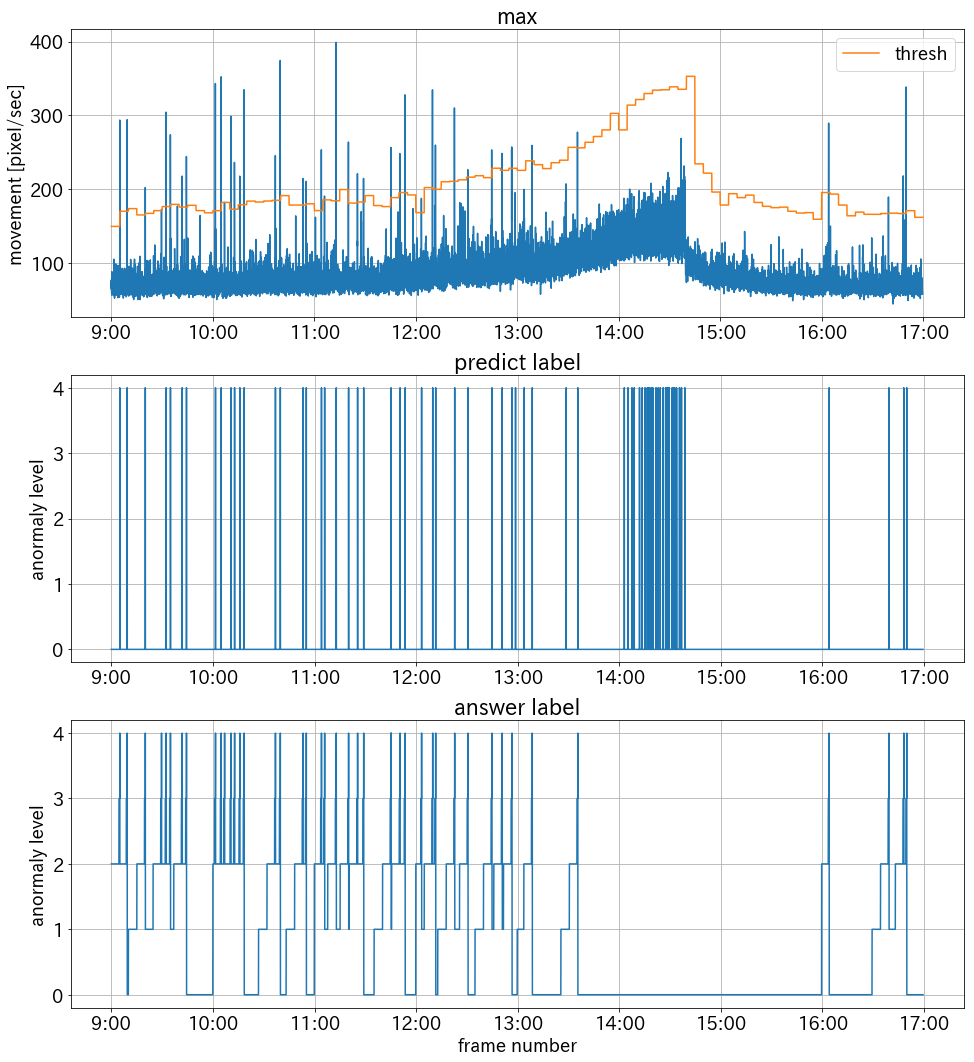

In [47]:
plt.figure(figsize=(16, 18))
plt.rcParams["font.size"] = 18

plt.subplot(3, 1, 1)
plt.plot(list(test_df["max"]))
plt.plot(thresh_lst, label="thresh")
plt.xticks([i*107900/30 for i in range(9)], ["9:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00", "16:00", "17:00"])
plt.legend()
plt.title("max")
plt.grid()
plt.ylabel("movement [pixel/sec]")

plt.subplot(3, 1, 2)
plt.plot(pred_test)
plt.xticks([i*107900/30 for i in range(9)], ["9:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00", "16:00", "17:00"])
plt.title("predict label")
plt.ylabel("anormaly level")
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(y_test)
plt.xticks([i*107900/30 for i in range(9)], ["9:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00", "16:00", "17:00"])
plt.title("answer label")
plt.ylabel("anormaly level")
plt.xlabel("frame number")
plt.grid()

In [36]:
importances = gbm.feature_importance()
indices = np.argsort(importances)[::-1]
cols = dataset_df.columns

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("{0}. {1} ({2})".format(f + 1, cols[indices[f]], importances[indices[f]]))

Feature ranking:
1. area_ratio (757)
2. Tue (283)
3. Wed (280)
4. mean (267)
5. var (234)
6. hour_14 (223)
7. max (215)
8. grid_0_1 (171)
9. hour_15 (167)
10. grid_0_4 (164)
11. degree_std (141)
12. grid_0_2 (140)
13. Sat (138)
14. hour_13 (132)
15. Fri (125)
16. hour_12 (122)
17. hour_11 (118)
18. max_shift1 (106)
19. grid_0_3 (105)
20. grid_0_5 (102)
21. hour_16 (102)
22. grid_0_0 (100)
23. Thurs (95)
24. var_shift1 (93)
25. grid_0_7 (92)
26. right_up (89)
27. Sun (87)
28. right_down (85)
29. horizontal (85)
30. grid_0_6 (83)
31. left (83)
32. mean_shift1 (82)
33. hour_10 (78)
34. hour_9 (75)
35. left_up (65)
36. degree_std_shift1 (61)
37. degree_mean_shift1 (57)
38. degree_mean (56)
39. Mon (51)
40. right (51)
41. oblique (49)
42. left_down (40)
43. feed_day (37)
44. diver_cur (32)
45. feed_cur (22)
46. diver_day (17)
47. down (15)
48. vertical (14)
49. up (12)
50. max_index_grid_0_2 (4)
51. overall_dir_right (3)
52. max_index_grid_0_3 (3)
53. overall_dir_left (2)
54. max_index_grid

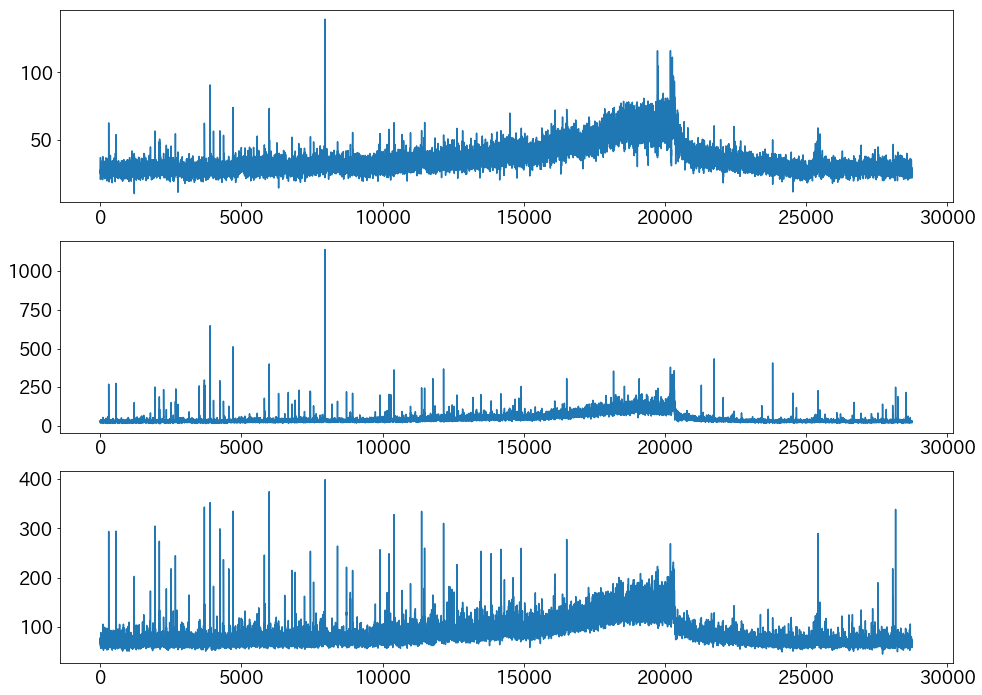

In [15]:
plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
plt.plot(list(test_df["mean"]))

plt.subplot(3, 1, 2)
plt.plot(list(test_df["var"]))

plt.subplot(3, 1, 3)
plt.plot(list(test_df["max"]))

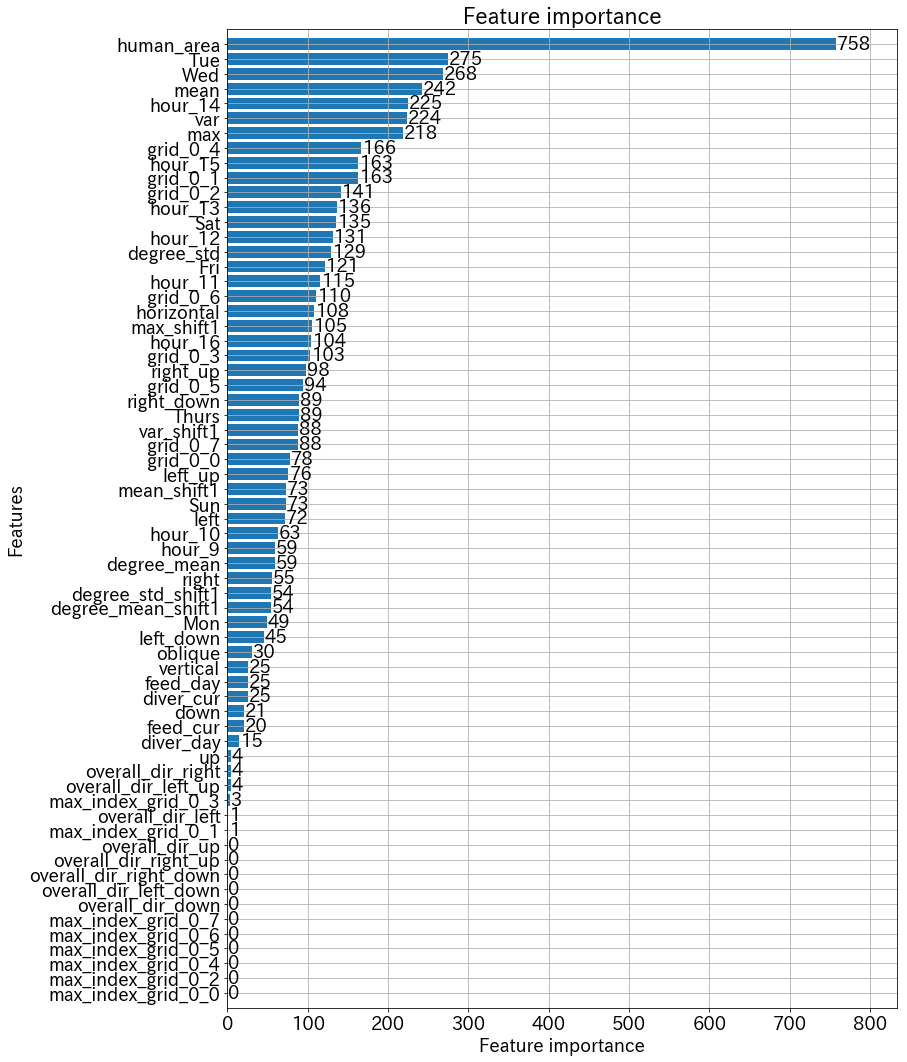

In [10]:
lgb.plot_importance(gbm, height=0.8, ignore_zero=False, figsize=(12, 18))
plt.show()
plt.savefig("./importance.png")

In [20]:
day_lst = ["20170416", "20170417", "20170418", "20170420", "20170421", "20170422", "20181030", "20181031"]
day2cnt = {}

for day in day_lst:
    dataset_df = pd.DataFrame()
    for t_idx in range(9, 17):
        tmp_dataset_df = pd.read_csv("../../data/datasets/{0}/default/time_series_{1}.csv".format(day, t_idx))

        # check NaN count
        assert tmp_dataset_df.isnull().values.sum() == 0

        dataset_df = pd.concat([dataset_df, tmp_dataset_df]).reset_index(drop=True)
    day2cnt[day] = np.sum(dataset_df["label"])

In [21]:
day2cnt

{'20170416': 62,
 '20170417': 78,
 '20170418': 74,
 '20170420': 65,
 '20170421': 38,
 '20170422': 84,
 '20181030': 153,
 '20181031': 159}